## 0. Importação das bibliotecas

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import re
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle


## 1. Carregando os dados

##### Iniciamos carregando o dataset a partir do arquivo csv disponibilizado e exibindo as primeiras linhas para visualização inicial da tabela.

In [56]:
df_prices = pd.read_csv('../data/raw/teste_indicium_precificacao.csv')
df_prices.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


## 2. EDA


##### Antes de iniciar a exploração dos dados, com base nas regras de negócio, temos as seguintes hipóteses, e iremos abordá-las durante a Análise Exploratória: 

##### Hipótese Nula (H₀): Não há relação significativa entre variáveis como localização, tipo de acomodação, disponibilidade e número de avaliações com o preço do aluguel.

##### Hipótese Alternativa 1 (H₁): A localização influencia significativamente o preço do aluguel. Espera-se que bairros mais valorizados apresentem preços médios mais altos.

##### Hipótese Alternativa 2 (H₂): O tipo de acomodação impacta o preço. Imóveis inteiros ("Entire home/apt") tendem a ter preços mais elevados do que quartos compartilhados ou privados.

##### 2.1. Descrição dos dados
##### Verificando as colunas, dimensões, tipos de dados e valores nulos.

In [57]:
## Visualizando as colunas do dataset
df_prices.columns

Index(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365'],
      dtype='object')

### 2.2. Dimensão dos dados

##### Verificando o nº de linhas e colunas


In [58]:
print('Número de linhas:{}'.format(df_prices.shape[0]))
print('Número de colunas:{}'.format(df_prices.shape[1]))

Número de linhas:48894
Número de colunas:16


### 2.3. Valores nulos

##### Para valores nulos, é necessário avaliar, de acordo com a regra de negócio, a necessidade de tratamento desses dados. 
##### Para isso, verifica-se a existência de valores nulos por meio da função abaixo:

In [59]:
df_prices.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

##### Nota-se a necessidade de tratar os dados da coluna nome e host_name, além de ultima_review e reviews_por_mes.

##### Para colunas nome e host_name, os valores nulos serão preenchidos por 'Desconhecido'; para valores as reviews em branco, será utilizado o valor '0' para substituição


In [60]:

df_prices = df_prices.assign(
    nome=df_prices['nome'].fillna('Desconhecido'),
    host_name=df_prices['host_name'].fillna('Desconhecido'),
    reviews_por_mes=df_prices['reviews_por_mes'].fillna(0)
)


##### Após o tratamento, é verificado os valores nulos novamente.

In [61]:
print(df_prices.isna().sum())


id                                   0
nome                                 0
host_id                              0
host_name                            0
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                      0
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


### 2.4. Tipo de dados

In [62]:
df_prices.dtypes

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

## 2.5. Estatística Descritiva

##### Realiza uma análise estatística descritiva dos atributos numéricos, incluindo média, mediana, desvio padrão, assimetria e curtose.


##### Divide os atributos em números e não categóricos, criando dois DataFrames distintos.

In [63]:
num_attributes = df_prices.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_prices.select_dtypes(include=['object']).columns

##### Para os atributos númericos, são calculadas as seguintes estatísticas descritivas:

### 2.5.1. Análise Univariada

In [64]:
## Tendências centrais

media = pd.DataFrame(num_attributes.apply(np.mean)).T

mediana = pd.DataFrame(num_attributes.apply(np.median)).T

## Dispersão

dispersion1 = pd.DataFrame(num_attributes.apply(np.std)).T  # Desvio padrão
dispersion2 = pd.DataFrame(num_attributes.apply(min)).T  # Valor mínimo
dispersion3 = pd.DataFrame(num_attributes.apply(max)).T  # Valor máximo
dispersion4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T  
dispersion5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dispersion6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


summary_stats = pd.concat([dispersion2, dispersion3, dispersion4, media, mediana, dispersion1, dispersion5, dispersion6]).T.reset_index()
summary_stats.columns = ['Atributos','Valor Mínimo','Valor Máximo', 'Amplitude', 'Media','Mediana','Desvio Padrão','Assimetria','Curtose']
summary_stats = summary_stats.applymap(lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x)


summary_stats

/tmp/ipykernel_58116/87578903.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_stats = summary_stats.applymap(lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x)


,Atributos,Valor Mínimo,Valor Máximo,Amplitude,Media,Mediana,Desvio Padrão,Assimetria,Curtose
0,id,"2,595.00","36,487,245.00","36,484,650.00","19,017,532.13","19,677,431.50","10,982,771.74",-0.09,-1.23
1,host_id,"2,438.00","274,321,313.00","274,318,875.00","67,621,393.58","30,795,529.00","78,610,372.25",1.21,0.17
2,latitude,40.50,40.91,0.41,40.73,40.72,0.05,0.24,0.15
3,longitude,-74.24,-73.71,0.53,-73.95,-73.96,0.05,1.28,5.02
4,price,0.00,"10,000.00","10,000.00",152.72,106.00,240.15,19.12,585.66
5,minimo_noites,1.00,"1,250.00","1,249.00",7.03,3.00,20.51,21.83,854.06
6,numero_de_reviews,0.00,629.00,629.00,23.27,5.00,44.55,3.69,19.53
7,reviews_por_mes,0.00,58.50,58.50,1.09,0.37,1.60,3.30,43.53
8,calculado_host_listings_count,1.00,327.00,326.00,7.14,1.00,32.95,7.93,67.55
9,disponibilidade_365,0.00,365.00,365.00,112.78,45.00,131.62,0.76,-1.00


##### O que se pode verificar a partir dessas métricas, é que há valores muito altos influenciando a média de disponibilidade, visto que a média é um valor muito mais alto que a mediana.

In [65]:
media_disponibilidade = df_prices["disponibilidade_365"].mean()
mediana_disponibilidade = df_prices["disponibilidade_365"].median()

print(f"Média da disponibilidade: {media_disponibilidade:.2f} dias")
print(f"Mediana da disponibilidade: {mediana_disponibilidade:.0f} dias")

Média da disponibilidade: 112.78 dias
Mediana da disponibilidade: 45 dias


##### Sobre os preços, também é notado o comportamento de valores altos influenciando a média.

In [66]:
media_precos = df_prices["price"].mean()
mediana_precos = df_prices["price"].median()

print(f"Média de preço: {media_precos:.2f} dias")
print(f"Mediana de preço: {mediana_precos:.0f} dias")

Média de preço: 152.72 dias
Mediana de preço: 106 dias


##### Abaixo há um histograma, para visualizar a distribuição de preços e se eles seguem uma distribuição normal.

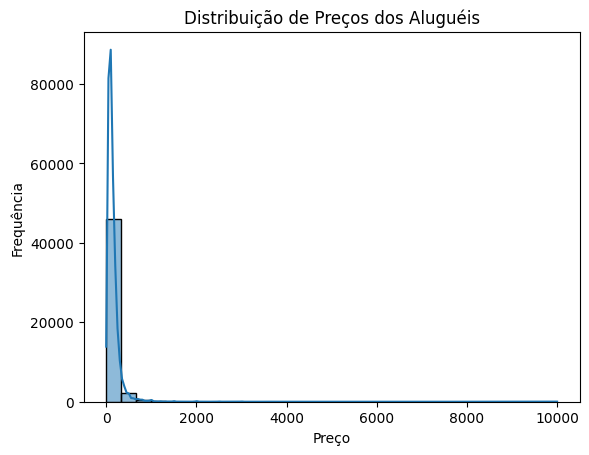

In [67]:
sns.histplot(df_prices["price"], bins=30, kde=True) 
plt.xlabel("Preço")
plt.ylabel("Frequência")
plt.title("Distribuição de Preços dos Aluguéis")
plt.show()

##### Também é interessante a visualização de um histograma com o mínimo de noites.

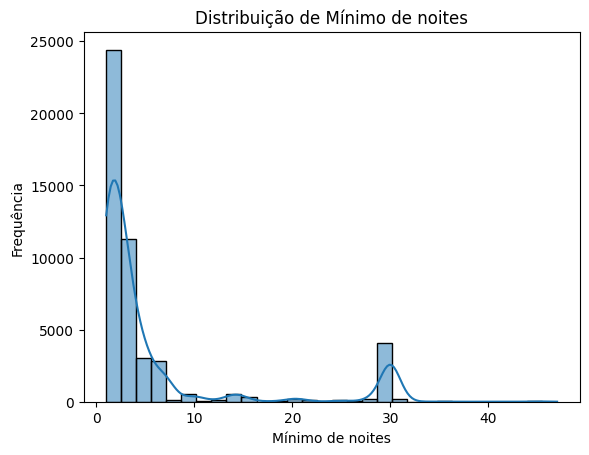

In [68]:
df_filtered = df_prices[df_prices["minimo_noites"] < 50]

sns.histplot(df_filtered["minimo_noites"], bins=30, kde=True) 
plt.xlabel("Mínimo de noites")
plt.ylabel("Frequência")
plt.title("Distribuição de Mínimo de noites")
plt.show()

### 2.5.2. Análise bivariada

##### Para verificar a correlação entre as variáveis, é feita a matriz de correlação:

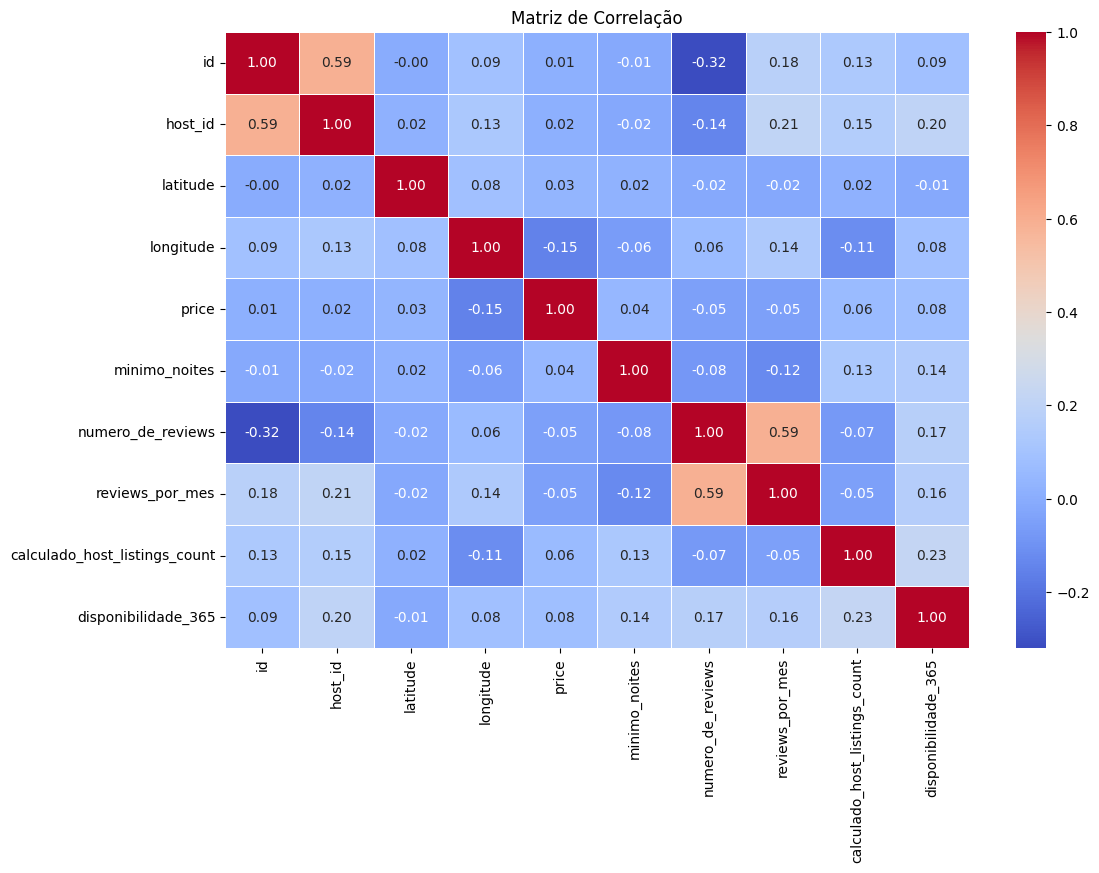

In [69]:

correlation_matrix = num_attributes.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação")
plt.show()

##### A partir da correlação, podemos ter os seguintes insights:

##### - A disponibilidade_365 tem correlação positiva (0.23) com a calculado_host_listing_count, que pode sugerir que anfitriões com mais imóveis tendem a ter suas propriedades disponíveis por mais dias.

##### - A correlação muito fraca entre preço e outras variáveis sugere que o preço das acomodações pode não ser fortemente influenciado por fatores como localização ou número de reviews. 

##### No boxplot, podemos verificar que nos preços existem muitos valores outliers.

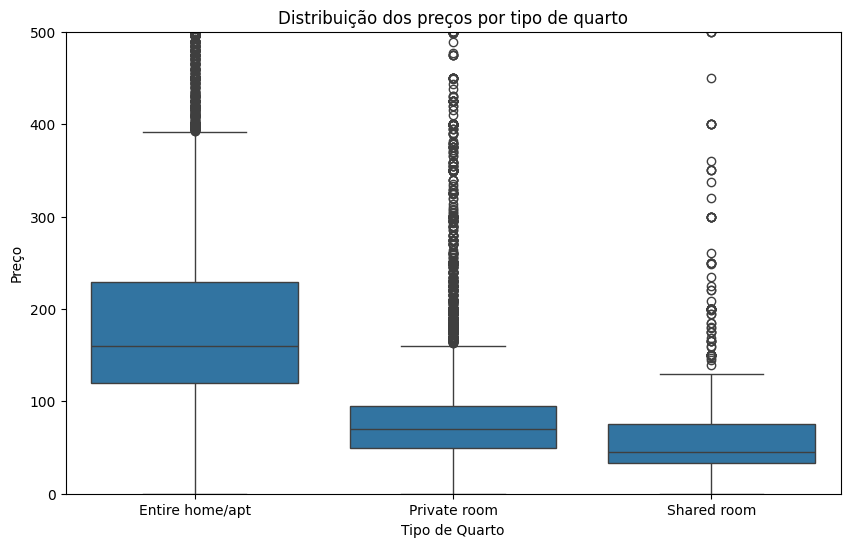

In [70]:
plt.figure(figsize=(10,6))
sns.boxplot(x="room_type", y="price", data=df_prices)
plt.ylim(0, 500)
plt.xlabel("Tipo de Quarto")
plt.ylabel("Preço")
plt.title("Distribuição dos preços por tipo de quarto")
plt.show()


##### Sobre a relação do preço com o número mínimo de noites, é possível gerar insights a partir da dispersão:

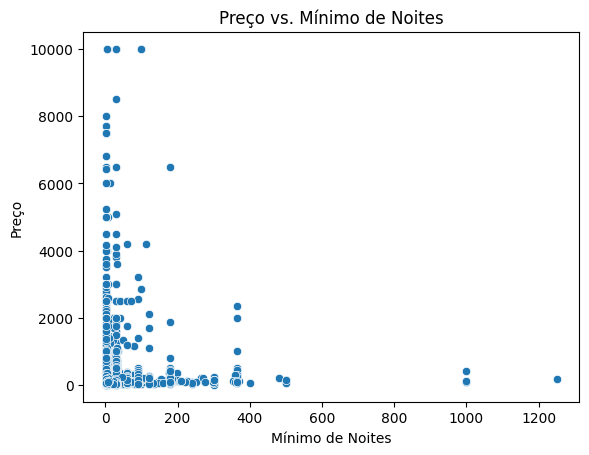

In [71]:
sns.scatterplot(x=df_prices["minimo_noites"], y=df_prices["price"])
plt.xlabel("Mínimo de Noites")
plt.ylabel("Preço")
plt.title("Preço vs. Mínimo de Noites")
plt.show()


##### Há anúncios com estadias mínimas muito altas, porém a distribuição parece estar concentrada em poucos dias de estadia e preços baixos.

##### Podemos também verificar o preço médio agrupado por tipo de quarto.

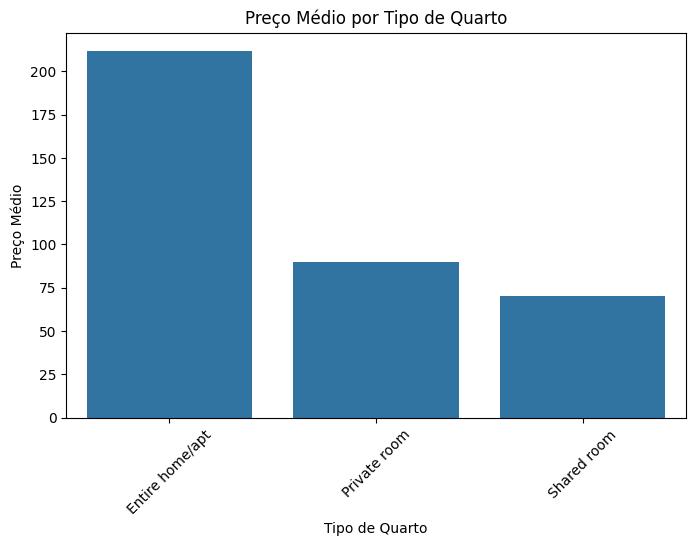

In [72]:
plt.figure(figsize=(8, 5))
sns.barplot(x="room_type", y="price", data=df_prices, estimator=lambda x: x.mean(), errorbar=None)
plt.xlabel("Tipo de Quarto")
plt.ylabel("Preço Médio")
plt.title("Preço Médio por Tipo de Quarto")
plt.xticks(rotation=45)
plt.show()


##### Se nota que casas ou apartamentos tem preços maiores em relação a quartos privados, e ainda maiores quando comparados a quartos compartilhados.

##### Também é possível extrair informações sobre o preço por grupo de bairros, como é visto a seguir:

In [73]:
preco_por_bairro = df_prices.groupby("bairro_group")["price"].mean().sort_values(ascending=False)
print(preco_por_bairro)


bairro_group
Manhattan        196.875814
Brooklyn         124.381983
Staten Island    114.812332
Queens            99.517649
Bronx             87.496792
Name: price, dtype: float64


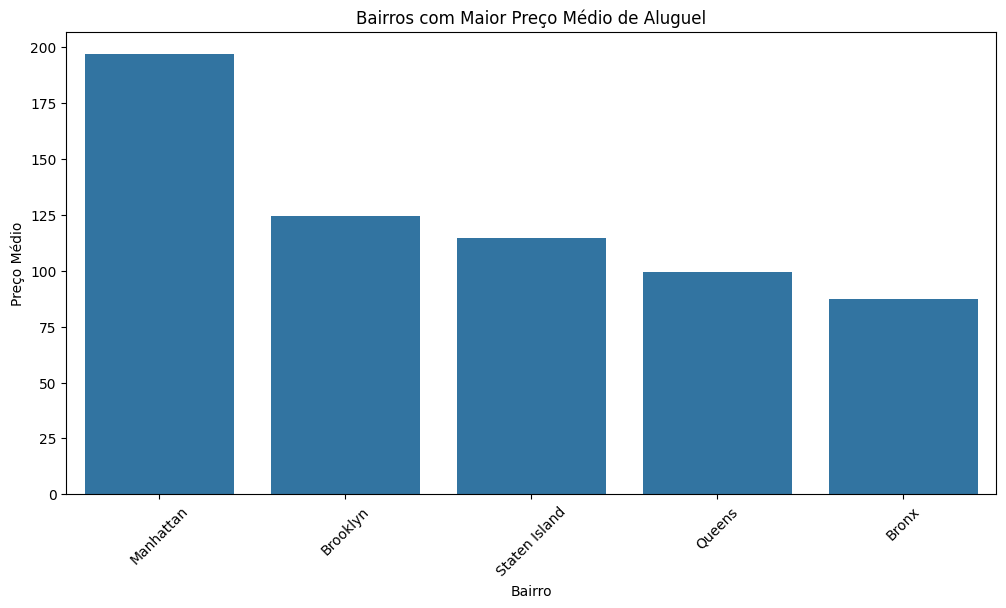

In [74]:

plt.figure(figsize=(12, 6))
top_bairros = preco_por_bairro.head(10)
sns.barplot(x=top_bairros.index, y=top_bairros.values)
plt.xticks(rotation=45)
plt.xlabel("Bairro")
plt.ylabel("Preço Médio")
plt.title("Bairros com Maior Preço Médio de Aluguel")
plt.show()


##### Os bairros com maior preço médio são os apresentados acima.

In [75]:

bairros_group_mapa = df_prices.groupby("bairro_group")[["latitude", "longitude", "price"]].mean().reset_index()

m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

heat_data = df_prices[['latitude', 'longitude', 'price']].values.tolist()

HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(m)

for _, row in bairros_group_mapa.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=f"{row['bairro_group']}: ${row['price']:.2f}",
        tooltip=row["bairro_group"]
    ).add_to(m)

m


##### No que diz respeito aos dias disponíveis, podemos verificar os bairros que tem maior disponibilidade para aluguel.

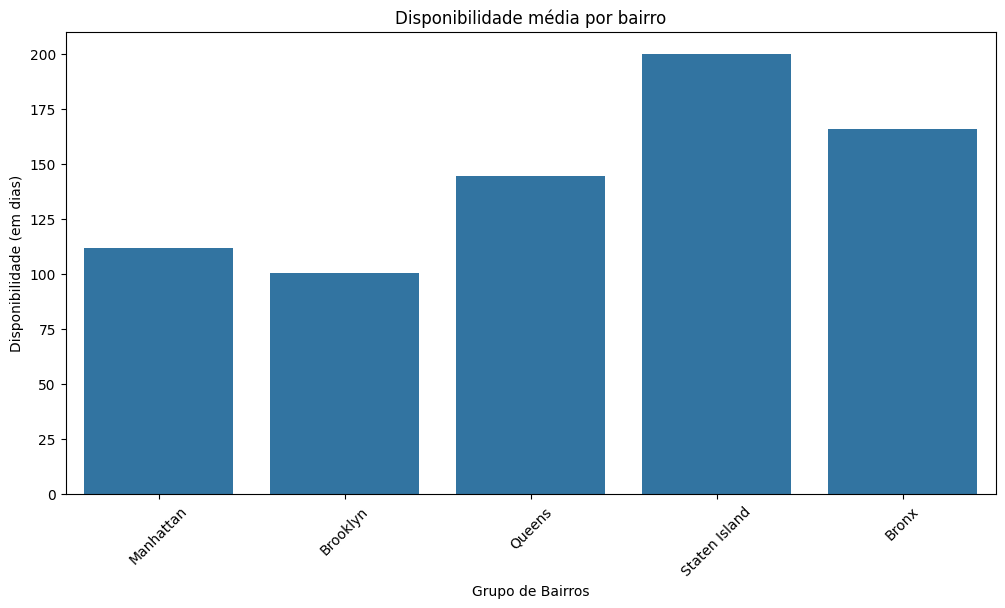

In [76]:
plt.figure(figsize=(12,6))
sns.barplot(x="bairro_group", y="disponibilidade_365", data=df_prices, errorbar=None)
plt.title("Disponibilidade média por bairro")
plt.xlabel("Grupo de Bairros")
plt.ylabel("Disponibilidade (em dias)")
plt.xticks(rotation=45)
plt.show()


##### Os bairros mais rentáveis são aqueles que possuem maior receita mensal, então para fazer um bom negócio ao escolher seu investimento, deve-se levar em consideração a taxa de ocupação, receita mensal e anúncios totais.

In [77]:
df_prices["reviews_por_mes"] = df_prices["reviews_por_mes"].fillna(0)
df_prices["disponibilidade_365"] = df_prices["disponibilidade_365"].replace(0, 1) 
df_prices["minimo_noites"] = df_prices["minimo_noites"].fillna(1)

df_prices["receita_mensal"] = df_prices["price"] * df_prices["reviews_por_mes"] * df_prices["minimo_noites"]

df_prices["taxa_de_ocupacao"] = (df_prices["reviews_por_mes"] * 30) / df_prices["disponibilidade_365"]

bairros_rentaveis = df_prices.groupby("bairro").agg(
    receita_mensal_media=("receita_mensal", "mean"),
    taxa_ocupacao_media=("taxa_de_ocupacao", "mean"),
    anuncios_totais=("id", "count")
).sort_values(by="receita_mensal_media", ascending=False)

print(bairros_rentaveis.head(5))





                   receita_mensal_media  taxa_ocupacao_media  anuncios_totais
bairro                                                                       
Nolita                      1741.250079             5.500565              253
Great Kills                 1302.260000             0.362640               10
Greenwich Village           1275.242296             4.137522              392
Roosevelt Island            1117.988442             5.055322               77
Flatiron District           1108.488500             3.256405               80


##### Também é interessante verificar a correlação entre as variáveis de preço, mínimo de noites e disponibilidade.

In [78]:
correlacao = df_prices[["price", "minimo_noites", "disponibilidade_365"]].corr()
print(correlacao)


                        price  minimo_noites  disponibilidade_365
price                1.000000       0.042799             0.081834
minimo_noites        0.042799       1.000000             0.144346
disponibilidade_365  0.081834       0.144346             1.000000


##### Todas as correlações acima foram vistas como fracas, então esses atributos tem baixo impacto no preço.

In [79]:
preco_medio_por_bairro = df_prices.groupby('bairro')['price'].mean().sort_values(ascending=False)

print(preco_medio_por_bairro.head(10))



bairro
Fort Wadsworth       800.000000
Woodrow              700.000000
Tribeca              490.638418
Sea Gate             487.857143
Riverdale            442.090909
Prince's Bay         409.500000
Battery Park City    367.557143
Flatiron District    341.925000
Randall Manor        336.000000
NoHo                 295.717949
Name: price, dtype: float64


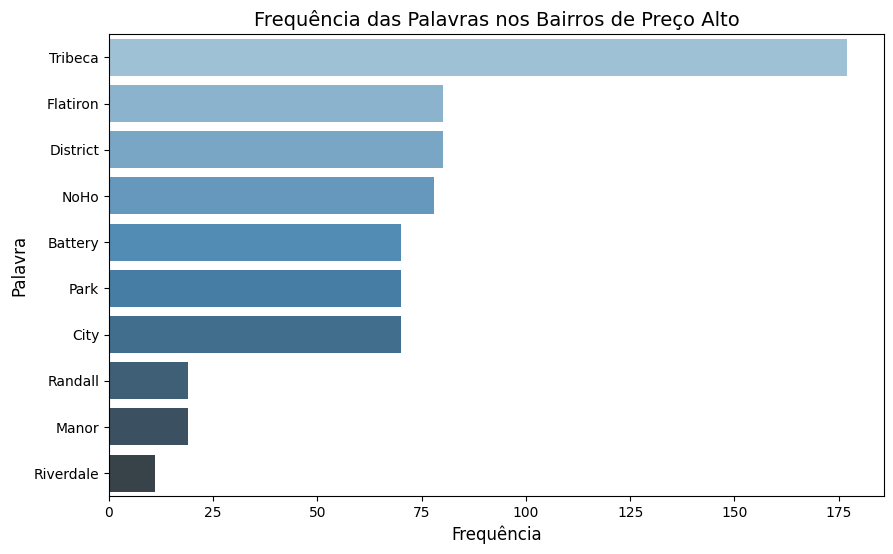

In [80]:
bairros_top_preco = preco_medio_por_bairro.head(10).index

df_top_bairros = df_prices[df_prices['bairro'].isin(bairros_top_preco)]

palavras_bairros_top = df_top_bairros['bairro'].str.split().explode()


# Contar a frequência das palavras
frequencia_palavras_top = Counter(palavras_bairros_top)

palavras_df = pd.DataFrame(frequencia_palavras_top.most_common(10), columns=['Palavra', 'Frequência'])

# Plotando o gráfico de barras com a correção
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequência', y='Palavra', data=palavras_df, hue='Palavra', palette='Blues_d', legend=False)

# Título e rótulos
plt.title('Frequência das Palavras nos Bairros de Preço Alto', fontsize=14)
plt.xlabel('Frequência', fontsize=12)
plt.ylabel('Palavra', fontsize=12)
plt.show()



## Respondendo as perguntas do desafio:

#### a) Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

##### Os bairros mais rentáveis são aqueles que possuem maior receita mensal, então para fazer um bom negócio ao escolher seu investimento, deve-se levar em consideração a taxa de ocupação, receita mensal e anúncios totais.

               receita_mensal_media  taxa_ocupacao_media  anuncios_totais
bairro_group                                                             
Manhattan                698.000885             4.753523            21661
Brooklyn                 427.071984             4.927635            20103
Staten Island            331.552869             3.061388              373
Queens                   326.750141             4.463032             5666
Bronx                    248.837516             3.448449             1091


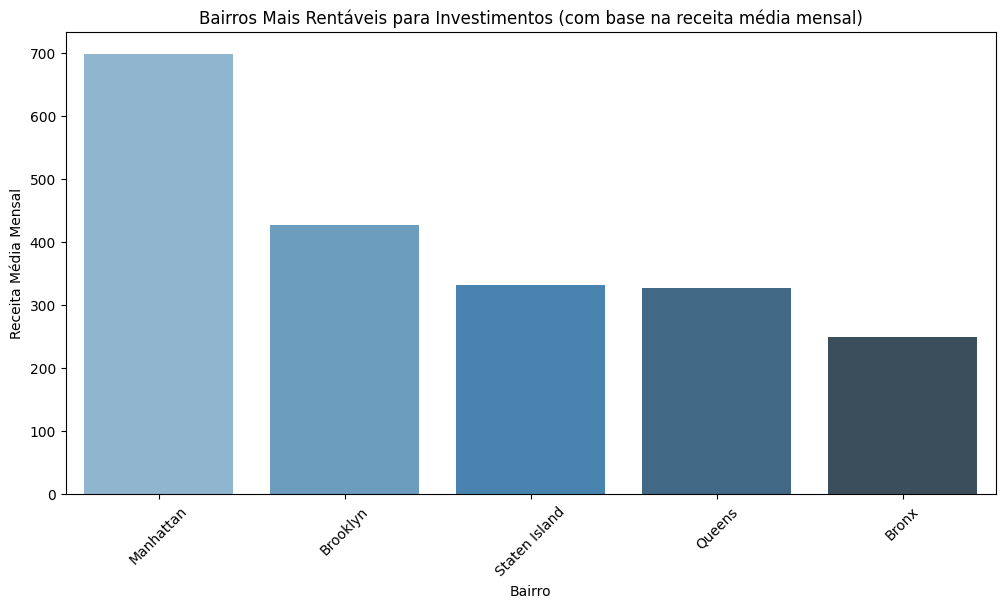

In [81]:
df_prices["reviews_por_mes"] = df_prices["reviews_por_mes"].fillna(0)
df_prices["disponibilidade_365"] = df_prices["disponibilidade_365"].replace(0, 1) 
df_prices["minimo_noites"] = df_prices["minimo_noites"].fillna(1)

df_prices["receita_mensal"] = df_prices["price"] * df_prices["reviews_por_mes"] * df_prices["minimo_noites"]

df_prices["taxa_de_ocupacao"] = (df_prices["reviews_por_mes"] * 30) / df_prices["disponibilidade_365"]

bairros_rentaveis = df_prices.groupby("bairro_group").agg(
    receita_mensal_media=("receita_mensal", "mean"),
    taxa_ocupacao_media=("taxa_de_ocupacao", "mean"),
    anuncios_totais=("id", "count")
).sort_values(by="receita_mensal_media", ascending=False)

print(bairros_rentaveis.head(5))


plt.figure(figsize=(12, 6))
sns.barplot(data=bairros_rentaveis.reset_index(), x="bairro_group", y="receita_mensal_media", hue="bairro_group", palette="Blues_d")
plt.xticks(rotation=45)
plt.xlabel("Bairro")
plt.ylabel("Receita Média Mensal")
plt.title("Bairros Mais Rentáveis para Investimentos (com base na receita média mensal)")
plt.show()

##### A análise sugere que os bairros mais rentáveis para alugar na plataforma são aqueles que possuem maior rentabilidade mensal, que são: Manhattann, Brooklyn, Staten Island, Queens e Bronx. Pois, possuem maior receita mensal levando em consideração o preço médio, número mínimo de noites e disponibilidade anual.

#### b) O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

##### Para verificar se o número mínimo de noites influencia no preço, podemos fazer uma correlação entre as variáveis.

In [82]:
df_prices[['minimo_noites', 'price']].corr()


,minimo_noites,price
minimo_noites,1.000000,0.042799
price,0.042799,1.000000


##### Como a correlação de Pearson calculada é positiva e fraca, pode-se inferir que o mínimo de noites pouco influencia no preço. 

##### Porém, pode haver influencia dos outliers, que são valores extremos, que podem distorcer a análise. Por isso, é importante verificar essa correlação após a remoção desses valores.

In [83]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25) 
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_prices_clean = remove_outliers(df_prices, "minimo_noites")
df_prices_clean = remove_outliers(df_prices_clean, "price")

correlation_cleaned = df_prices_clean[['minimo_noites', 'price']].corr()
print(correlation_cleaned)

               minimo_noites     price
minimo_noites       1.000000  0.059912
price               0.059912  1.000000


##### Após a limpeza e remoção de outliers, foi possível notar um ligeiro aumento, porém ainda é uma correlação fraca: 0.059912.

##### No que tange a correlação com disponibilidade, é possível verificar se há correlação por meio da seguinte função:

In [84]:
df_prices[['disponibilidade_365', 'price']].corr()


,disponibilidade_365,price
disponibilidade_365,1.000000,0.081834
price,0.081834,1.000000


##### A correlação indica que disponibilidade não tem uma relação linear forte com o preço dos aluguéis.

#### c) Existe algum padrão no texto do nome do local para lugares de mais alto valor?

In [85]:
bairros_investimento = df_prices_clean.groupby('bairro')['price'].mean().reset_index()

top_bairros = bairros_investimento.nlargest(10, 'price')

palavras_bairros = top_bairros['bairro'].apply(lambda x: re.findall(r'\w+', x.lower())).explode()

contador_palavras = Counter(palavras_bairros)

# Exibir as 10 palavras mais comuns
print("Palavras mais comuns nos bairros de maior preço:")
for palavra, contagem in contador_palavras.most_common(10):
    print(f"{palavra}: {contagem}")

Palavras mais comuns nos bairros de maior preço:
village: 2
district: 2
willowbrook: 1
neponsit: 1
breezy: 1
point: 1
noho: 1
west: 1
tribeca: 1
flatiron: 1


##### A análise dos nomes dos bairros dos imóveis mais caros revela que termos como "village", "tribeca", "greenwich", "noho" e "west" aparecem com frequência, embora em pequenas quantidades. 

### 3. Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?


##### Como o objetivo principal é fazer uma previsão a partir dos dados, a base da predição dos preços serão as variáveis de bairro, preço, número mínimo de noites, disponibilidade ao longo do ano e outras características do imóvel. Esse é um problema de regressão linear.

##### Como já fizemos a análise exploratória e tratamos os dados, podemos dividir o conjunto de dados em treinamento e teste:


In [86]:
## Variável dependente (y)
y = df_prices_clean['price']

## Remove a variável alvo
X = df_prices_clean.drop(columns=['price'])

# Remover colunas indesejadas antes de definir os atributos categóricos
X = X.drop(columns=['host_name', 'id', 'host_id', 'nome'], errors='ignore')

# Definir colunas categóricas após a remoção
cat_attributes = X.select_dtypes(include=['object']).columns

# Aplicar One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=cat_attributes, drop_first=True)

print(X_encoded.head())


   latitude  longitude  minimo_noites  numero_de_reviews  reviews_por_mes  \
0  40.75362  -73.98377              1                 45             0.38   
1  40.80902  -73.94190              3                  0             0.00   
2  40.68514  -73.95976              1                270             4.64   
3  40.79851  -73.94399             10                  9             0.10   
4  40.74767  -73.97500              3                 74             0.59   

   calculado_host_listings_count  disponibilidade_365  receita_mensal  \
0                              2                  355           85.50   
1                              1                  365            0.00   
2                              1                  194          412.96   
3                              1                    1           80.00   
4                              1                  129          354.00   

   taxa_de_ocupacao  bairro_group_Brooklyn  ...  ultima_review_2019-06-29  \
0          0.032113  

##### Treinando e criando o modelo

In [87]:

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)

modelo_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

##### Teste do modelo

In [88]:
y_pred = modelo_rf.predict(X_test)

##### Avaliando o modelo

In [89]:

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Exibir os resultados
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 22.02
MSE: 1162.03
RMSE: 34.09
R²: 0.7445


###### De acordo com os testes, é indicado que o modelo tem o Erro Médio Absoluto de 22.02 dólares para cada previsão. Além disso, o Erro Quadrático Médio, que indica a presença de valores extremos, temos o RMSE (Raiz do Erro Quadrático Médio) = 34.09, que indica que os erros do modelo são de $34,09. Por fim, temos o R² (Coeficiente de Determinação) = 0.7445, que indica que o modelo explica 74,45% da variabilidade dos preços.

##### Para fazer a sugestão do preço do aluguel do apartamento, cria-se um dataframe com as informações do apartamento em questão e utiliza-se o modelo treinado com o dataset dos aluguéis.

In [90]:
novo_apt = pd.DataFrame([{
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}])

nova_entrada_encoded = pd.get_dummies(novo_apt, columns=['bairro_group', 'bairro', 'room_type'], drop_first=True)
nova_entrada_encoded = novo_apt.reindex(columns=X_encoded.columns, fill_value=0)


In [91]:
previsao = modelo_rf.predict(nova_entrada_encoded)
print(f'Preço previsto: ${previsao[0]:.2f}')


Preço previsto: $196.89


##### Dessa forma, conclui-se que o preço sugerido pelo modelo, com base nos valores especificados no problema, é de cerca de $196.89.

## e) Salvar o arquivo Pickle

In [92]:
with open("modelo_rf.pkl", "wb") as f:
    pickle.dump(modelo_rf, f)
